## Dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

# NYPD Civilian Complaints
This project contains data on 12,000 civilian complaints filed against New York City police officers. 

### Getting the Data
The data and its corresponding data dictionary is downloadable [here](https://www.propublica.org/datastore/dataset/civilian-complaints-against-new-york-city-police-officers).

#### Import NYPD Allegations data

In [2]:
allegations = pd.read_csv('allegations.csv')
allegations.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,...,39,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A)


### Introduction

The nypd dataset provides lots of useful data to perform a wide variety of demographic and temporal analysis regarding police allegations. 

The question I decided to investigate is:

<b>Are female complainants more likely to recieve an 'Arrest - other violation/crime' outcome for the same nypd contact reasons as males?</b>

In reference to the question I posed above, I decided to use the `complainant_gender` `contact_reason`, and `outcome_description` attributes of the dataset to perform my analysis.

#### Select relevant data

In [3]:
df = allegations[['complainant_gender', 'contact_reason', 'outcome_description']]
df.head()

,complainant_gender,contact_reason,outcome_description
0,Female,Report-domestic dispute,No arrest made or summons issued
1,Male,Moving violation,Moving violation summons issued
2,Male,Moving violation,Moving violation summons issued
3,Male,PD suspected C/V of violation/crime - street,No arrest made or summons issued
4,NaN,Report-dispute,Arrest - other violation/crime


### Data Cleaning
The data pre-processing steps are:
- Replace 'Not described' in `gender` with `NaN`
- Replace 'No contact' in `contact_reasons` with `NaN`
- Replace `Resisting Arrest/Arrested` with `Arrest - resisting arrest`
- We cannot fill null values as we cannot assume gender, reason for contact, or outcome of contact, so they are left null

I proceeded to transform the gender column by simplying it into two categories: "Females" and "Non-Females"

#### Check data for missing values or values that should be classified as missing

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33358 entries, 0 to 33357
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   complainant_gender   29163 non-null  object
 1   contact_reason       33159 non-null  object
 2   outcome_description  33302 non-null  object
dtypes: object(3)
memory usage: 782.0+ KB


In [5]:
df['complainant_gender'].value_counts()

Male                     24058
Female                    5021
Not described               57
Transwoman (MTF)            20
Transman (FTM)               5
Gender non-conforming        2
Name: complainant_gender, dtype: int64

In [6]:
df['contact_reason'].value_counts().reset_index().tail(10)

,index,contact_reason
43,PD telephones CV,18
44,Complainant at Pct. to make a Cmpl/info,16
45,EDP Aided Cases,12
46,Telephone Call to Precinct/Command,11
47,Transit checkpoint,11
48,Aided Cases,10
49,Demonstrations,8
50,Complainant Witnessing Incident,5
51,No contact,3
52,Victim Subject of Sex Crime,2


In [7]:
df['outcome_description'].value_counts().reset_index().tail(10)

,index,outcome_description
13,Traffic Summons Claimed or Issued,59
14,Juvenile Report,57
15,Other Summons Claimed or Issued,38
16,Assault/Arrested,34
17,Resisting Arrest/Arrested,25
18,Arrest - harrassment (against a PO),15
19,Obstruct-Govt-Admin/Arrested,10
20,Harrassment/Arrested/Summons,8
21,Summons - harrassment (against a PO),5
22,Summons - OGA,1


The data does have null values, as well as values that should be classified as missing

#### Cleaning the data appropriately and replacing data that should be missing with `NaN`

- 'Not described' in `gender` should be `NaN`
- 'No contact' in `contact_reasons` should be `NaN`
- Resisting Arrest/Arrested is the same as Arrest - resisting arrest
- We cannot fill null values as we cannot assume gender, reason for contact, or outcome of contact

In [8]:
df = df.replace({'Not described': np.NaN, 'Resisting Arrest/Arrested': 'Arrest - resisting arrest', 
                 'No contact': np.NaN})

#### Data Transformation

Transforming gender data to fit the question

In [9]:
df['complainant_gender'] = df['complainant_gender'].apply(lambda x: x if x == 'Female' else 'Non-Female')
df.head()

,complainant_gender,contact_reason,outcome_description
0,Female,Report-domestic dispute,No arrest made or summons issued
1,Non-Female,Moving violation,Moving violation summons issued
2,Non-Female,Moving violation,Moving violation summons issued
3,Non-Female,PD suspected C/V of violation/crime - street,No arrest made or summons issued
4,Non-Female,Report-dispute,Arrest - other violation/crime


### Exploratory Data Analysis
The EDA steps I followed were constrained by the categorical nature of the variables in question
- For `complainant_gender`, I plotted a bar graph to understand the frequency distribution of genders of complainants
- For `contact_reason`, I plotted the frequency distribution of the 5 most common reasons police make contact with people who write allegations
- For `outcome_description`, I similarly plotted the frequency distribution of the 5 most common encounter outcomes police have with those who wrote the allegations 
- I created a pivot table of the proportions that Females and Non-Females are arrested for `Other violations / crimes` for the top 5 contact reasons and plotted it.
- To get an understanding of how to solve the question, I also plotted a pivot table of the proportions of all outcomes for Females vs Non-Females. This revealed that the largest discrepancy is `Arrests for Other violations / crimes` between the different genders

### Univariate Analysis

As our data is categorical in nature, we can not analyze it quantitatively. We can analyse the proportions of each category

Text(0, 0.5, 'Proportion')

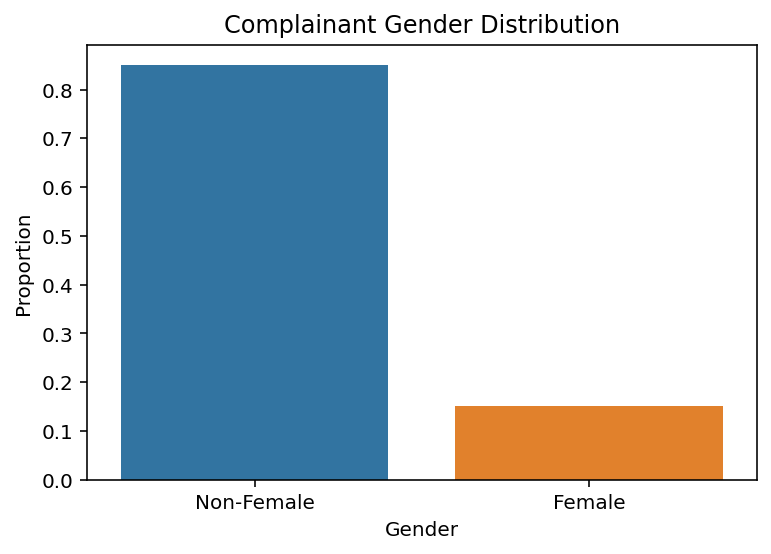

In [10]:
gender_prop = df['complainant_gender'].value_counts(normalize=True).reset_index() # Calculate proportions for gender
ax = sns.barplot(x='index', y='complainant_gender', data=gender_prop) 
ax.set_title('Complainant Gender Distribution')
ax.set_xlabel('Gender')
ax.set_ylabel('Proportion')

There are far too many obscure contact reasons to visualize. We will use the 5 most common ones in our visualization, but work with all contact reasons in our tests

In [11]:
top_contacts = df['contact_reason'].value_counts(normalize=True).reset_index()[:5]['index'] # Calculate proportions for contact_reasons

Text(0, 0.5, 'Proportion')

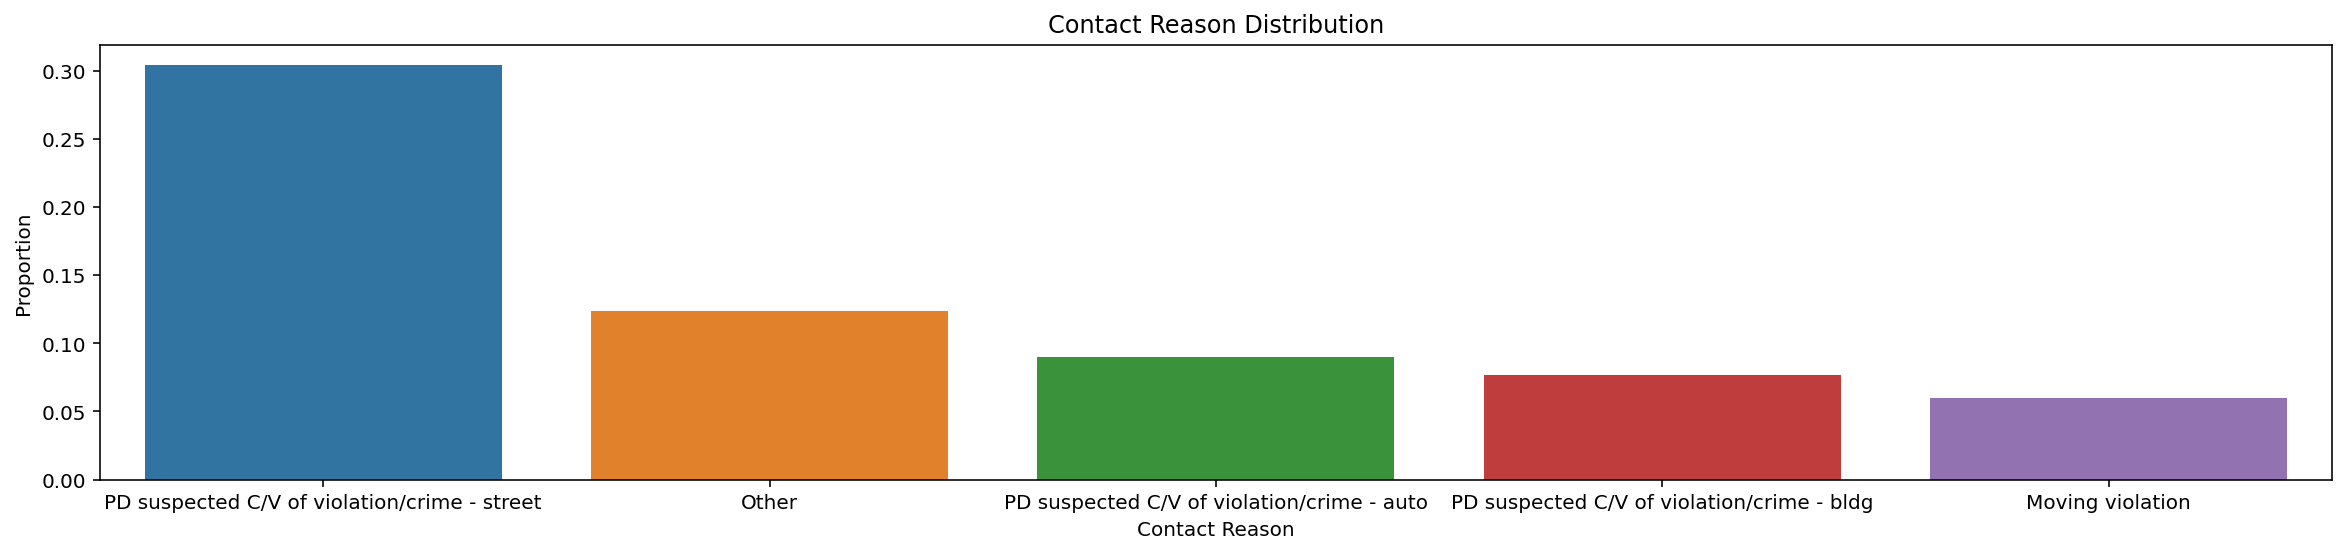

In [12]:
plt.figure(figsize=(20,4))
contact_prop = df['contact_reason'].value_counts(normalize=True).reset_index()[:5] #Top 5 contact_reasons by NYPD
ax = sns.barplot(x=contact_prop['index'], y=contact_prop['contact_reason'])
ax.set_title('Contact Reason Distribution')
ax.set_xlabel('Contact Reason')
ax.set_ylabel('Proportion')

There are far too many obscure encounter outcomes to visualize. We will use the 5 most common ones in our visualization, but work with all contact reasons in our tests

In [13]:
top_outcomes = df['outcome_description'].value_counts(normalize=True).reset_index()[:5]['index']

Text(0, 0.5, 'Proportion')

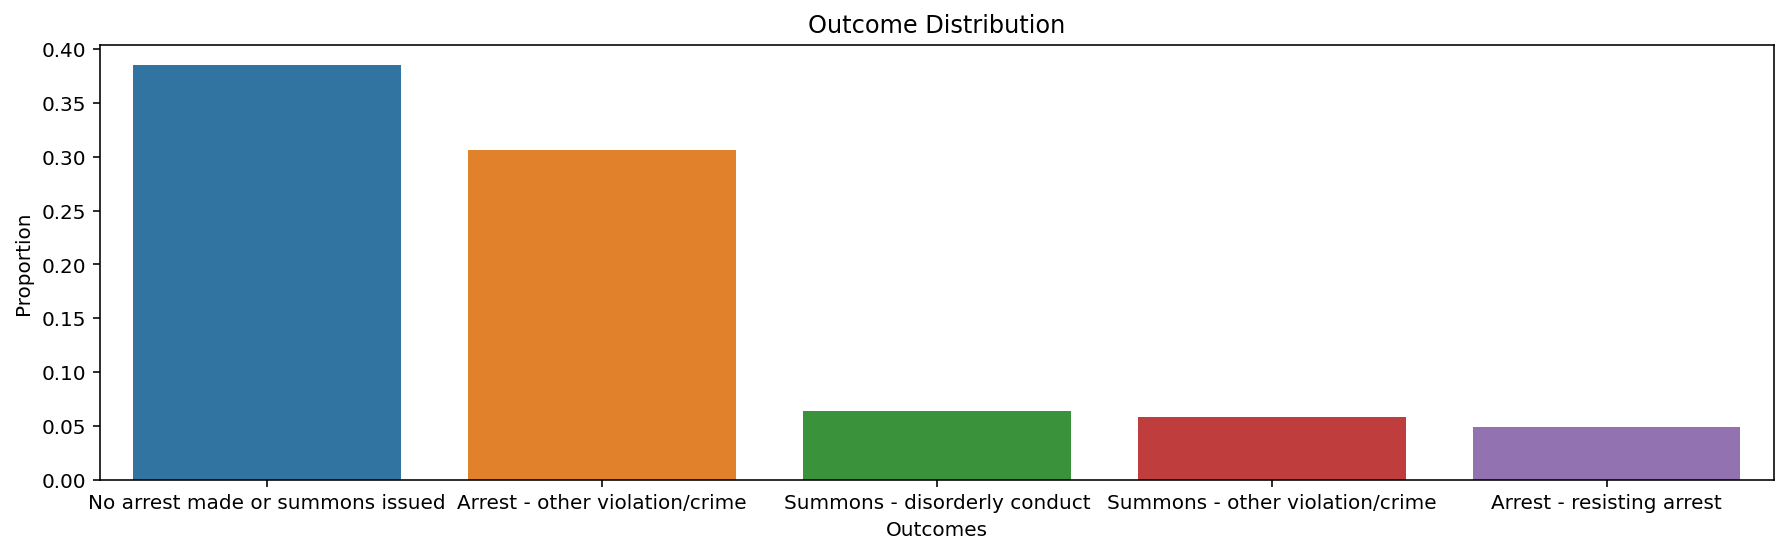

In [14]:
plt.figure(figsize=(15,4))
outcome_prop = df['outcome_description'].value_counts(normalize=True).reset_index()[:5]
ax = sns.barplot(x=outcome_prop['index'], y=outcome_prop['outcome_description']) #Top 5 outcomes for NYPD encounts
ax.set_title('Outcome Distribution')
ax.set_xlabel('Outcomes')
ax.set_ylabel('Proportion')

### Bivariate Analysis

a pivot table of the proportions that Females and Non-Females are 'Arrested for Other violations / crimes' as well as the contact reasons by the police officer / complainant

In [15]:
non_arrests = df[df['outcome_description'] == 'Arrest - other violation/crime'].pivot_table(
    index='complainant_gender',
    columns='contact_reason',
    values='outcome_description',
    aggfunc='count'
).apply(lambda x: x / x.sum(), axis=1) #To calculate proportions

non_arrests

contact_reason,Aided case,Assist ACS or other agency,C/V at PCT to file complaint of crime,C/V at PCT to obtain information,C/V at PCT to retrieve property,C/V intervened on behalf of/observed encounter w/3rd party,C/V requested info from officer,C/V requested investigation of crime,C/V telephoned PCT,CV already in custody,...,Parking violation,Regulatory inspection,Report of other crime,Report-dispute,Report-domestic dispute,Report-gun possession/shots fired,Report-noise/disturbance,Report-possession/sale of narcotics,Traffic accident,Transit checkpoint
complainant_gender,,,,,,,,,,,,,,,,,,,,,
Female,0.004258,0.003041,0.00365,0.007299,0.003041,0.006691,0.000608,0.016423,0.007299,0.009124,...,0.015207,0.003041,0.055353,0.086375,0.037713,0.017640,0.010949,0.017640,0.008516,NaN
Non-Female,0.001880,0.001880,NaN,0.002468,0.000588,0.020919,0.000940,0.005524,0.006464,0.009402,...,0.008579,0.000470,0.035609,0.032319,0.023269,0.017863,0.008697,0.023034,0.005289,0.000353


A side by side plot of the most popular contact reasons with their corresponding proportions of Arrests for other reasons by gender

Text(0, 0.5, 'Proportion')

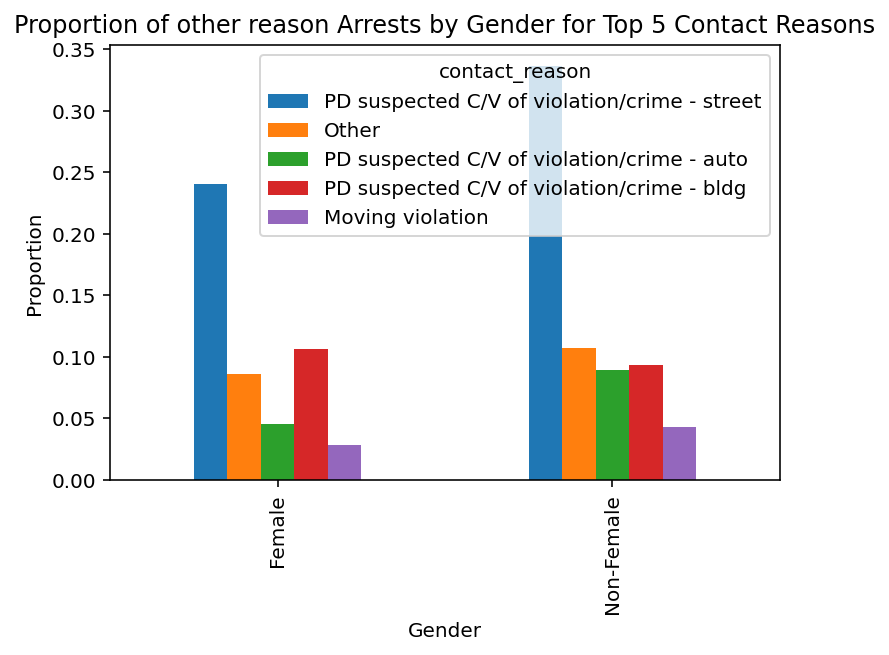

In [16]:
non_arrests[top_contacts.values].plot(kind='bar')
plt.title('Proportion of other reason Arrests by Gender for Top 5 Contact Reasons')
plt.xlabel('Gender')
plt.ylabel('Proportion')

### Aggregate Analysis

In [17]:
out = df.pivot_table(
    index='complainant_gender',
    columns='outcome_description',
    values='contact_reason',
    aggfunc='count'
).apply(lambda x: x / x.sum(), axis=1)

out

outcome_description,Arrest - OGA,Arrest - assault (against a PO),Arrest - disorderly conduct,Arrest - harrassment (against a PO),Arrest - other violation/crime,Arrest - resisting arrest,Arrest on Other Charge,Assault/Arrested,Disorderly-Conduct/Arr/Summons,Harrassment/Arrested/Summons,...,No arrest made or summons issued,Obstruct-Govt-Admin/Arrested,Other Summons Claimed or Issued,Other VTL violation summons issued,Parking summons issued,Summons - OGA,Summons - disorderly conduct,Summons - harrassment (against a PO),Summons - other violation/crime,Traffic Summons Claimed or Issued
complainant_gender,,,,,,,,,,,,,,,,,,,,,
Female,0.022723,0.026543,0.034788,NaN,0.330585,0.043837,NaN,NaN,NaN,NaN,...,0.384074,NaN,NaN,0.010859,0.007239,NaN,0.066559,0.001005,0.051679,NaN
Non-Female,0.019020,0.025597,0.029721,0.000533,0.302510,0.049772,0.00288,0.001209,0.004871,0.000284,...,0.382821,0.000356,0.001351,0.016852,0.008639,0.000036,0.063353,NaN,0.059834,0.002098


This graph shows the difference in proportions for all kinds of outcomes between females and non-females. For the most part, the lines appear to be mostly straight - with the exception of `Arrest - other violation/crime.` We will explore this further in the hypothesis test

Text(0, 0.5, 'Proportion')

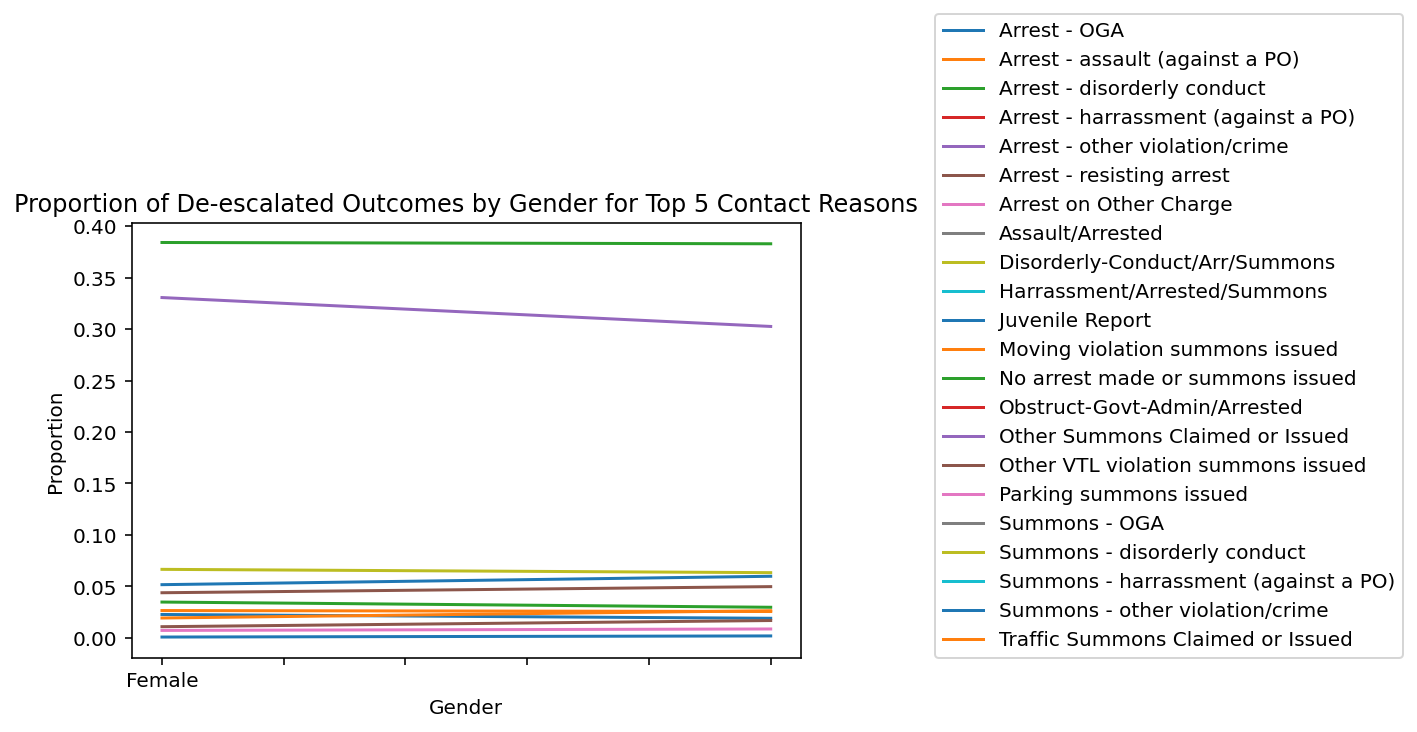

In [18]:
out.plot(kind='line')
plt.legend(loc=(1.2, 0))
plt.title('Proportion of De-escalated Outcomes by Gender for Top 5 Contact Reasons')
plt.xlabel('Gender')
plt.ylabel('Proportion')

### Assessment of Missingness
- To assess missingness of my data, I decided to utilize permutation tests with the KS-Statistic. 
- I performed two permutation tests, fixing a 5% significance level and 95% confidence level, to determine if `outcome_description` is MAR (Missing At Random) dependent on both the `contact_reason` and the `allegation` field of the larger dataset under the null hypothesis that there is no dependency. 
- I believe that the data is not NMAR (Not Missing At Random) for the first test. It would make sense for data with outcomes to have filed a reason for contact. If data is missing in the `outcome_description`, it is probably connected to data missing in the `contact_reason`. However, I also believe that the data is NMAR for the second test. This is because if data is missing in the `outcome_description`, there is no good reason for the gender of the complainant to be missing as these sections of the data are unrelated.
-  The first permutation test yields a p-value of 0.043 and the second a p-value of 0.345. With these values, I can confidently assert whether to accept or reject the null-hypothesis (i.e., no dependency). 
- The results indicate that `outcome_description` is MAR dependent on `contact_reason` but not on `allegation`. My intuitions were correct.

#### Is the outcome_description missing at random dependent on contact_reason?

I believe that the data is not NMAR in this instance. It would make sense for data with outcomes to have filed a reason for contact, without which there would probably be repercussions. If data is missing in the outcome description, it is probably connected to data missing in the contact reason

**Null hypothesis:** outcome_description is not MAR dependent on contact_reason
- This is a good null hypothesis as it does not assume dependence

**Alternative hypothesis:** outcome_description is MAR dependent on contact_reason
- This is a good Alternative hypothesis as rejects the null hypothesis in a binary fashion

**Significance Level:** 0.05
- This is the default p-value used to determine significance with 95% confidence

**Test statistic:** KS-Statistic
- This is the default p-value used to determine significance with 95% confidence

In [19]:
import util

In [20]:
df_mar = df.copy()
df_mar['contact_reason'] = df_mar['contact_reason'].astype(str)
distr, obs = util.permutation_test(df_mar.assign(is_null=df_mar.outcome_description.isnull()), 'contact_reason',  'is_null', util.ks)
pval = (distr >= obs).mean()
pval

0.035

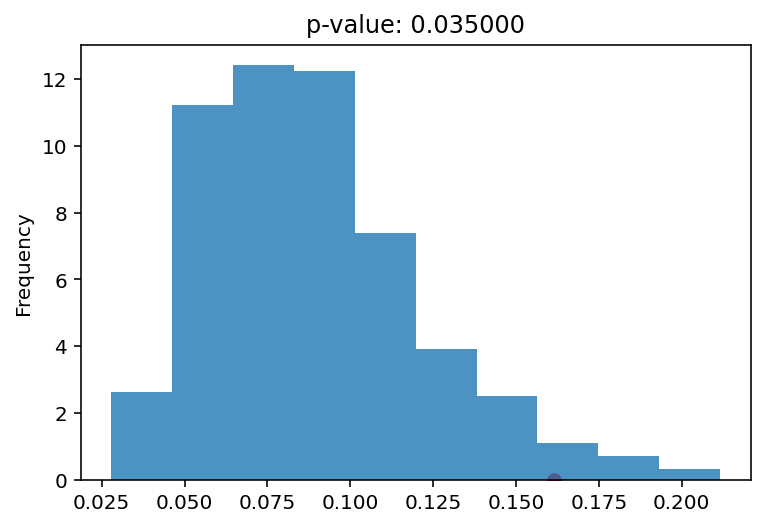

In [21]:
pd.Series(distr).plot(kind='hist', density=True, alpha=0.8, title='p-value: %f' % pval)
plt.scatter(obs, 0, color='red', s=40);

**Conclusion:** At a 5% significance level, we reject the null hypothesis in favour of the alternative hypothesis. Hence, outcome_description is MAR dependent on contact_reason

#### Is the outcome_description missing at random dependent on complainant_gender?

I believe that the data is NMAR in this instance. If data is missing in the outcome description, there is no good reason for the gender of the complainant to be missing as these sections of the data are unrelated.

**Null hypothesis:** outcome_description is not MAR dependent on complainant_gender
- This is a good null hypothesis as it does not assume dependence

**Alternative hypothesis:** outcome_description is MAR dependent on complainant_gender
- This is a good Alternative hypothesis as rejects the null hypothesis in a binary fashion

**Significance Level:** 0.05
- This is the default p-value used to determine significance with 95% confidence

**Test statistic:** KS-Statistic
- KS-statistics roughly measures the area between two distributions.

In [22]:
df_mar = allegations[['board_disposition', 'outcome_description']]
df_mar['board_disposition'] = df_mar['board_disposition'].astype(str)
distr, obs = util.permutation_test(df_mar.assign(is_null=df_mar.outcome_description.isnull()), 'board_disposition',  'is_null', util.ks)
pval = (distr >= obs).mean()
pval

C:\Users\arjun\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0.33

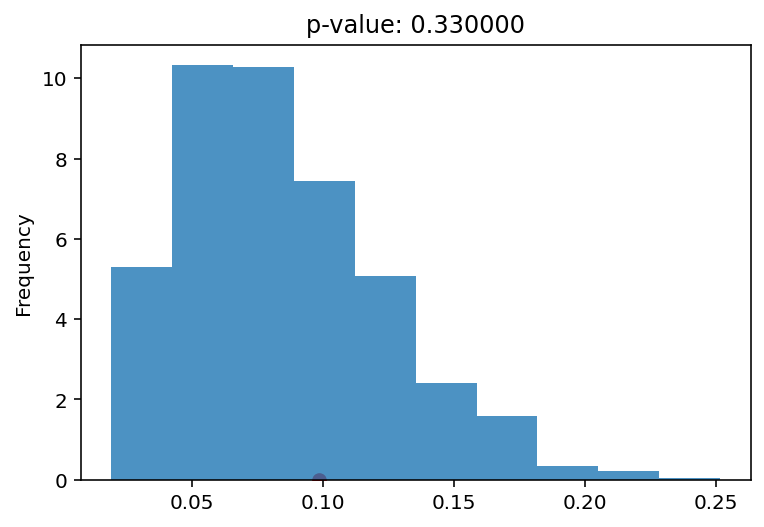

In [23]:
pd.Series(distr).plot(kind='hist', density=True, alpha=0.8, title='p-value: %f' % pval)
plt.scatter(obs, 0, color='red', s=40);

**Conclusion:** At a 5% significance level, we fail to reject the null hypothesis. Hence, outcome_description is not MAR dependent on contact_reason

### Hypothesis Test
- To answer the question I posed at the beginning, I conducted a hypothesis test under the null hypothesis that Females and Non-Females are equally to recieve a `Arrest - other violation/crime` outcome for the same contact reasons. The alternate hypothesis dictates that Females are more likely to recieve such an outcome.
- I used total variation distance as my test statistic, and fixed a significance level of 0.05. The p-value I got after running 1000 iterations was approximately 0.385, which was not low enough to reject the null-hypothesis. 
- Hence, I concluded that Females and Non-Females are equally to recieve a `Arrest - other violation/crime` outcome for the same contact reasons.

**Null-hypothesis:** Female complainants are not more likely to recieve a 'Arrest - other violation/crime' outcome for the same contact reasons. 

- This is a good null hypothesis as it does not assume dependence

**Alternative-hypothesis:** Female complainants are more likely to recieve a 'Arrest - other violation/crime' outcome for the same contact reasons
- This is a good alternative hypothesis as it rejects the null hypothesis and is not two-sided

**Significance Level:** 0.05
- This is the default p-value used to determine significance with 95% confidence

In [24]:
non_arrests = df[df['outcome_description'] == 'Arrest - other violation/crime'].pivot_table(
    index='complainant_gender',
    columns='contact_reason',
    values='outcome_description',
    aggfunc='count',
    fill_value=0
).apply(lambda x: x / x.sum(), axis=1)

non_arrests

contact_reason,Aided case,Assist ACS or other agency,C/V at PCT to file complaint of crime,C/V at PCT to obtain information,C/V at PCT to retrieve property,C/V intervened on behalf of/observed encounter w/3rd party,C/V requested info from officer,C/V requested investigation of crime,C/V telephoned PCT,CV already in custody,...,Parking violation,Regulatory inspection,Report of other crime,Report-dispute,Report-domestic dispute,Report-gun possession/shots fired,Report-noise/disturbance,Report-possession/sale of narcotics,Traffic accident,Transit checkpoint
complainant_gender,,,,,,,,,,,,,,,,,,,,,
Female,0.004258,0.003041,0.00365,0.007299,0.003041,0.006691,0.000608,0.016423,0.007299,0.009124,...,0.015207,0.003041,0.055353,0.086375,0.037713,0.017640,0.010949,0.017640,0.008516,0.000000
Non-Female,0.001880,0.001880,0.00000,0.002468,0.000588,0.020919,0.000940,0.005524,0.006464,0.009402,...,0.008579,0.000470,0.035609,0.032319,0.023269,0.017863,0.008697,0.023034,0.005289,0.000353


**Test statistic: Total variation distance**
- This is a good test statistic as it measures the distance between two distributions. In this case, the distributions are the proportions of Arrest - other violation/crime for the genders for each contact reason in the dataset

In [25]:
# Helper function to calculate TVD, taken from inherentialthinking.com
def tvd(distribution_1, distribution_2):
    return sum(np.abs(distribution_1 - distribution_2)) / 2

In [26]:
obs = tvd(non_arrests.loc['Female'], non_arrests.loc['Non-Female'])
obs

0.20535384174592297

**Hypothesis Test:**

In [27]:
tvds = []

# 1000 iterations
for _ in range(1000):
    # sample entire dataset with replacement
    table = df.sample(frac=1, replace=True)

    # create pivot table, replace NaNs with 0 as we are counting in our aggregation function
    pivot = table[table['outcome_description'] == 'Arrest - other violation/crime'].pivot_table(
        index='complainant_gender',
        columns='contact_reason',
        values='outcome_description',
        aggfunc='count',
        fill_value=0
    ).apply(lambda x: x / x.sum(), axis=1) # calculate proportion
        
    tvds.append(tvd(pivot.loc['Female'], pivot.loc['Non-Female']))

**Results:**

Text(0, 0.5, 'count')

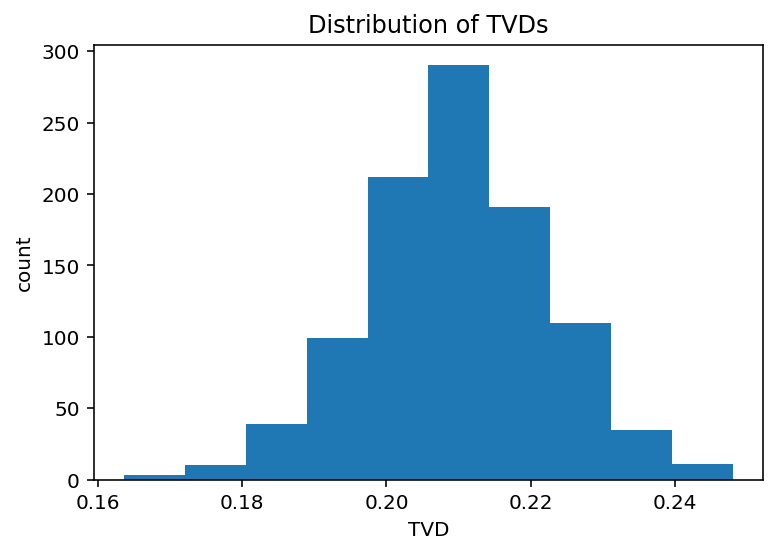

In [28]:
plt.hist(tvds)
plt.title('Distribution of TVDs')
plt.xlabel('TVD')
plt.ylabel('count')

**p-value**

In [29]:
np.count_nonzero(pd.Series(tvds) <= obs) / 1000

0.349

**Conclusion:** We fail to reject the null hypothesis. That is, female complainants are not more likely to not be arrested or not be issued summons than other complainants for the same contact reasons